In [64]:
import numpy as np                     # Packages for Data Analysis
import pandas as pd
import random as rand
from scipy.signal import correlate, correlation_lags

import matplotlib.pyplot as plt       # Packages for making plots
from matplotlib.patches import FancyArrow
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
from matplotlib.patches import Patch, Circle
from matplotlib.lines import Line2D
from scipy.ndimage import gaussian_filter1d

import braingeneers                  # Braigneneers packages for analysis
from braingeneers.analysis.analysis import SpikeData, read_phy_files, load_spike_data, burst_detection, randomize_raster
import braingeneers.data.datasets_electrophysiology as ephys

# Simulate randomized data

In [37]:
width = 16
N_channels = width * width
length_ms = 120 * 1000 # 120 seconds
average_rate = 0.5 # Average firing rate in Hz#

# Generate spike times
np.random.seed(0)
train = []

for _ in range(N_channels):
    num_spikes = np.random.poisson(average_rate * length_ms / 1000)
    spike_times = np.random.uniform(0, length_ms, num_spikes)
    train.append(spike_times)

# Correct the generation of positions for each neuron (channel) in a 16x16 grid
positions = [(x, y) for x in range(width) for y in range(width)]


# Initialize neuron_data with positions
neuron_data = {'positions': {i: {'position': positions[i]} for i in range(N_channels)}}

spike_data = SpikeData(train, neuron_data=neuron_data)

# Check some properties of the generated SpikeData object
spike_data_info = {
    "Number of Channels": spike_data.N,
    "Recording Length (ms)": spike_data.length,
    "Example Spike Times for First Channel": spike_data.train[0][:10]  # First 10 spikes
}

In [38]:
# Function to get neuron positions
def get_neuron_positions(spike_data):
    # Extract neuron positions from spike_data
    neuron_x = []
    neuron_y = []
    for neuron in spike_data.neuron_data['positions'].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
    neuron_positions = np.array([neuron_x, neuron_y]).T
    return neuron_positions

In [39]:
neuron_positions = get_neuron_positions(spike_data)

/tmp/ipykernel_3062/2894875950.py:6: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data['positions'].values():


In [34]:
def plot_raster(sd):
    idces, times = sd.idces_times()
    # Adjust the figsize parameter to change the figure size; (width, height) in inches
    fig, ax = plt.subplots(figsize=(10, 6))  # Example: 10 inches wide by 6 inches tall

    ax.scatter(times/1000, idces, marker='|', s=1)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    plt.show()


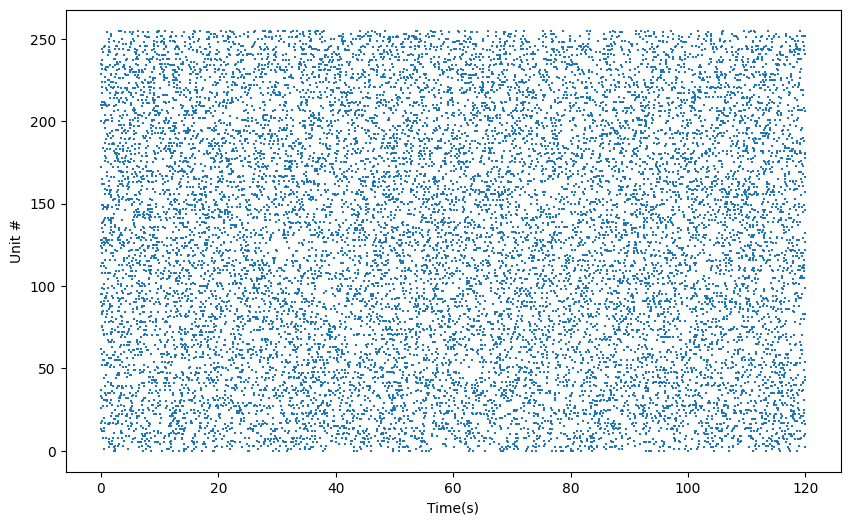

In [35]:
plot_raster(spike_data)

In [74]:
def calculate_mean_firing_rates(spike_data):
    mean_firing_rates = []
    for neuron_spikes in spike_data.train:
        num_spikes = len(neuron_spikes)
        time_duration = spike_data.length / 1000  # Assuming spike times are in milliseconds
        firing_rate = num_spikes / time_duration
        mean_firing_rates.append(firing_rate)

    return np.array(mean_firing_rates)

# Custom colormap from pale red/pink to dark red/black
colors = ["#ffcccb", "#ff6961", "#ff5c5c", "#ff1c00", "#bf0000", "#800000", "#400000", "#000000"]
cmap_name = "custom_red_black"
n_bins = 100  # More bins will give us a finer gradient
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

def firing_plotter(sd):
    firing_rates = calculate_mean_firing_rates(sd)
    neuron_x, neuron_y = [], []

    # Extract neuron positions
    for i, neuron in sd.neuron_data['positions'].items():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])

    # Adjust size scaling for more variance
    min_rate, max_rate = np.min(firing_rates), np.max(firing_rates)
    sizes = ((firing_rates - min_rate) / (max_rate - min_rate) * 300) + 10  # Normalize and scale

    plt.figure(figsize=(8, 6))
    # scatter = plt.scatter(neuron_x, neuron_y, s=sizes/1.5, c=firing_rates, alpha=0.6, cmap=cm)
    scatter = plt.scatter(neuron_x, neuron_y, s=sizes/1.5, c=firing_rates, alpha=0.6, cmap=cm)
    plt.title("Neuron Firing Rates")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.colorbar(scatter, label='Firing Rate (Hz)')
    plt.show()

/tmp/ipykernel_3062/3863927784.py:22: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for i, neuron in sd.neuron_data['positions'].items():


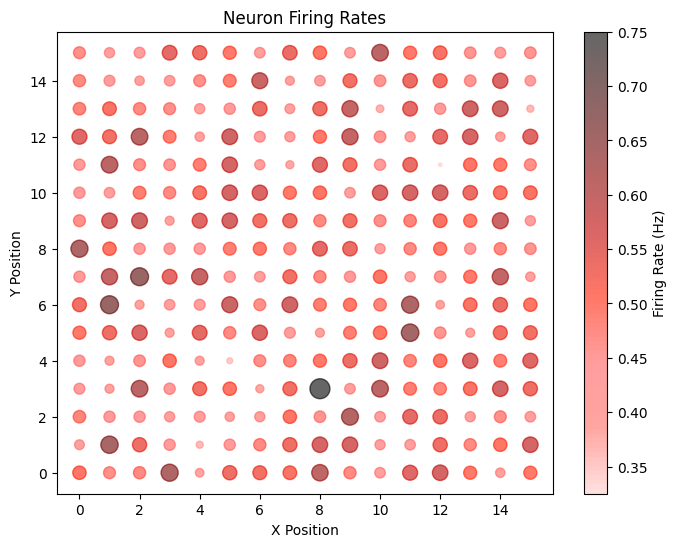

In [75]:
firing_plotter(spike_data)

# Simulated propagation

In [87]:
total_duration_ms = 60 * 1000  # 60 seconds in milliseconds
num_propagations = 5
rows, cols = 16, 16
N_channels = rows * cols
segment_duration_ms = total_duration_ms / num_propagations  # Duration of each propagation segment

positions = [(x, y) for x in range(rows) for y in range(cols)]

# Initialize neuron_data with positions
neuron_data = {'positions': {i: {'position': positions[i]} for i in range(N_channels)}}

# Initialize train with empty lists for each channel
train_patterned = [[] for _ in range(N_channels)]

# Generate spike times for the specified pattern
for propagation in range(num_propagations):
    segment_start = propagation * segment_duration_ms
    row_duration_ms = segment_duration_ms / rows  # Time allocated for each row to fire

    for row in range(rows):
        row_start = segment_start + (row * row_duration_ms)
        # Assign a single spike time in the middle of each row's allocated duration
        spike_time = row_start + row_duration_ms / 2

        for col in range(cols):
            channel_index = row * cols + col
            train_patterned[channel_index].append(spike_time)

# Convert lists to numpy arrays for consistency with previous dataset
train_patterned = [np.array(times) for times in train_patterned]

# Update the SpikeData object for the new dataset
spike_data_patterned = SpikeData(train=train_patterned, neuron_data=neuron_data)

# Check the first few spike times for the first few channels as a quick verification
spike_data_patterned_info = {
    "Example Spike Times for First Channel": spike_data_patterned.train[0],
    "Example Spike Times for Second Channel": spike_data_patterned.train[1]
}

In [83]:
total_duration_ms = 60 * 1000  # 60 seconds in milliseconds
num_propagations = 5
rows, cols = 16, 16
N_channels = rows * cols
segment_duration_ms = total_duration_ms / num_propagations  # Duration of each propagation segment


# Adjust parameters for overlap and longer breaks
overlap_duration_ms = 100  # Overlap duration in milliseconds
increased_break_duration_ms = total_duration_ms * 0.2 / num_propagations  # 20% of total time divided by num_propagations for breaks

# Adjust segment duration to account for increased breaks
adjusted_segment_duration_ms = (total_duration_ms - increased_break_duration_ms * num_propagations) / num_propagations

# Recalculate row_duration_ms to include overlap
row_duration_ms_with_overlap = adjusted_segment_duration_ms / rows + overlap_duration_ms

# Reinitialize train with empty lists for each channel
train_patterned_adjusted = [[] for _ in range(N_channels)]

positions = [(x, y) for x in range(rows) for y in range(cols)]

# Initialize neuron_data with positions
neuron_data = {'positions': {i: {'position': positions[i]} for i in range(N_channels)}}

# Generate spike times with overlap and adjusted breaks
for propagation in range(num_propagations):
    segment_start = propagation * (adjusted_segment_duration_ms + increased_break_duration_ms)
    
    for row in range(rows):
        row_start = segment_start + (row * (row_duration_ms_with_overlap - overlap_duration_ms))
        spike_times = np.linspace(row_start, row_start + row_duration_ms_with_overlap, 3)[:-1]  # Generate 2 spikes for overlap

        for col in range(cols):
            channel_index = row * cols + col
            train_patterned_adjusted[channel_index].extend(spike_times)

# Convert lists to numpy arrays for consistency
train_patterned_adjusted = [np.array(times) for times in train_patterned_adjusted]

# Update the SpikeData object for the new dataset with overlaps and longer breaks
spike_data_patterned_adjusted = SpikeData(train=train_patterned_adjusted, N=N_channels, length=total_duration_ms, neuron_data=neuron_data)

# Check the first few spike times for the first few channels as a quick verification
spike_data_patterned_adjusted_info = {
    "Example Spike Times for First Channel": spike_data_patterned_adjusted.train[0][:5],  # First 5 spikes
    "Example Spike Times for Second Channel": spike_data_patterned_adjusted.train[1][:5]  # First 5 spikes
}

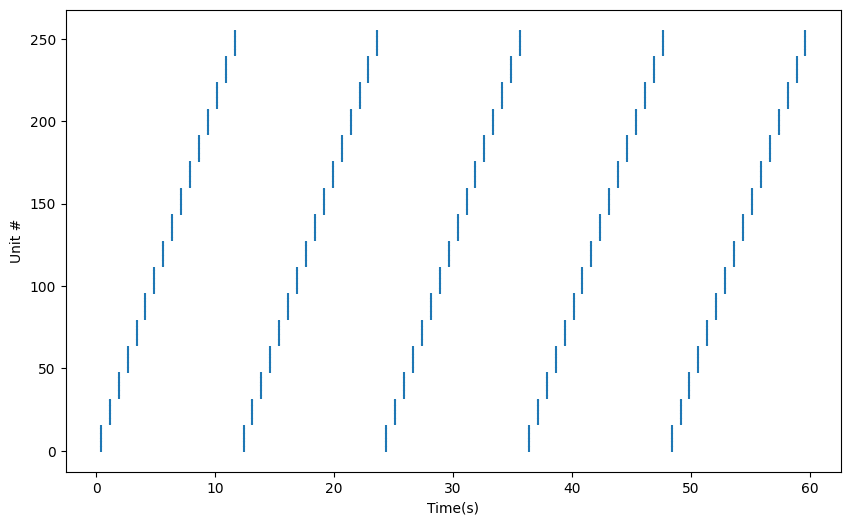

In [88]:
plot_raster(spike_data_patterned)

/tmp/ipykernel_3062/3863927784.py:22: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for i, neuron in sd.neuron_data['positions'].items():
/tmp/ipykernel_3062/3863927784.py:28: RuntimeWarning: invalid value encountered in divide
  sizes = ((firing_rates - min_rate) / (max_rate - min_rate) * 300) + 10  # Normalize and scale


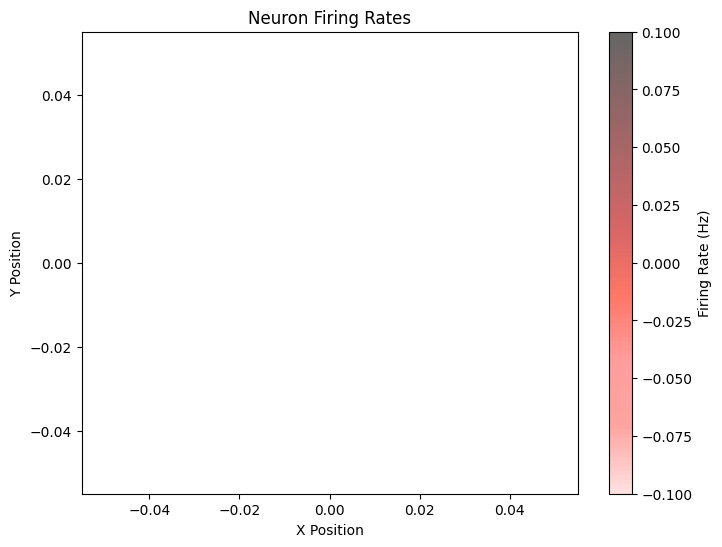

In [89]:
firing_plotter(spike_data_patterned)